   
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему.
Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать
пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом.
Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2024-12-06 по 2024-12-12. 

Анализ результатов флешмоба приведен ниже.


In [1]:
# Общий пакет для работы с временными рядами
import orbit
from orbit.models import DLT  # Для использования модели DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components  # Для графиков предсказаний

In [2]:
# Библиотеки для работы с данными
import pandas as pd
import pandahouse as ph  # Для использования ClickHouse
import numpy as np
import os

In [3]:
# Библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az  # Полезно для визуализации MCMC

In [5]:
# Машинное обучение и вероятностные модели
import tensorflow as tf
import tensorflow_probability as tfp

In [6]:
# Анализ причинно-следственного влияния
from causalimpact import CausalImpact

In [7]:
# Установка периодов для анализа
pre_period = [pd.Timestamp('2024-10-26'), pd.Timestamp('2024-12-05')]
post_period = [pd.Timestamp('2024-12-06'), pd.Timestamp('2024-12-12')]

In [33]:
#создаем шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [3]:
# Подключаемся к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

In [52]:
# Общий вид метрик
q = """
SELECT toDate(time) AS date, uniqExact(post_id) as posts, uniqExact(user_id) AS dau,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20241220.feed_actions
GROUP BY date
"""
df = ph.read_clickhouse(q, connection=connection)
df.set_index('date', inplace=True, drop=False)
df.head()

,date,posts,dau,likes,views,ctr
date,,,,,,
2024-10-26,2024-10-26,89,878,1560,7603,0.205182
2024-10-27,2024-10-27,178,2238,12816,62770,0.204174
2024-10-28,2024-10-28,191,3105,20958,105526,0.198605
2024-10-29,2024-10-29,211,3721,23800,118996,0.200007
2024-10-30,2024-10-30,214,4617,34504,174454,0.197783


### 1. DAU

Отдельный датафрейм df_dau

In [53]:
q = """
SELECT toDate(time) AS date,
       COUNT(DISTINCT user_id) AS dau
FROM simulator_20241220.feed_actions 
GROUP BY date
"""
df_dau = ph.read_clickhouse(q, connection=connection)
df_dau.set_index('date', inplace=True, drop=False)
df_dau.head()

,date,dau
date,,
2024-10-26,2024-10-26,878
2024-10-27,2024-10-27,2238
2024-10-28,2024-10-28,3105
2024-10-29,2024-10-29,3721
2024-10-30,2024-10-30,4617


Посмотрим на метрику на графике

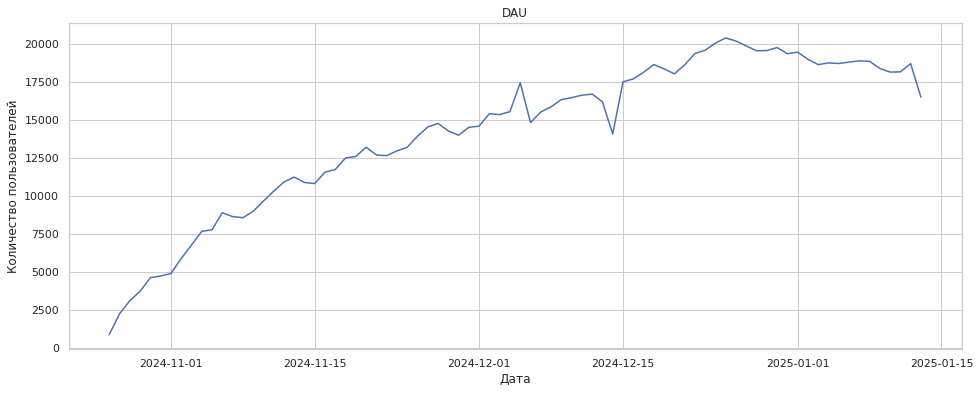

In [55]:
sns.lineplot(x='date', y='dau', data=df_dau)
plt.title('DAU')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей');

2025-01-13 16:07:04.745464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:07:04.770460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:07:05.318989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:

2025-01-13 16:07:20.044625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2025-01-13 16:07:20.120000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15060.19 (1068.91) 105421.34 (7482.35)
95% CI                    [12975.7, 17165.74][90829.9, 120160.2]

Absolute effect (s.d.)    992.52 (1068.91)   6947.66 (7482.35)
95% CI                    [-1113.03, 3077.01][-7791.2, 21539.1]

Relative effect (s.d.)    6.59% (7.1%)       6.59% (7.1%)
95% CI                    [-7.39%, 20.43%]   [-7.39%, 20.43%]

Posterior tail-area probability p: 0.18
Posterior prob. of a causal effect: 81.62%

For more details run the command: print(impact.summary('report'))


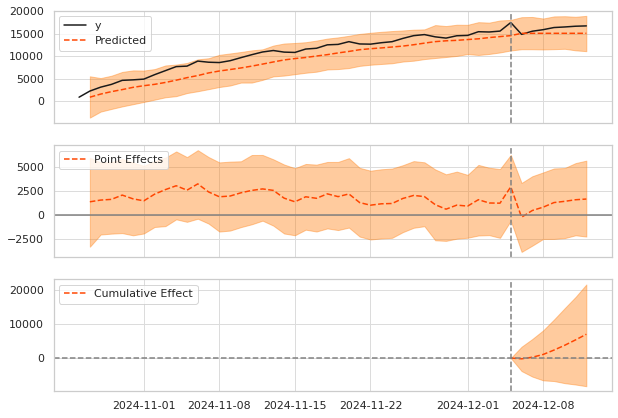

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 15060.19.
The 95% interval of this counterfactual prediction is [12975.7, 17165.74].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 992.52 with a 95% interval of
[-1113.03, 3077.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 105421.34. The 95% interval of this prediction is [90829.9, 120160.2].


The above results are given in terms of absolute numbers. In relative
terms, the response variabl

In [56]:
# Создание модели CausalImpact для анализа DAU
impact_dau = CausalImpact(data=df_dau[['dau']], pre_period=pre_period, post_period=post_period)

# Вывод результатов
print(impact_dau.summary())
impact_dau.plot()
print(impact_dau.summary('report'));

***Вывод: Положительные эффект DAU не является статистически значимым. DAU значимо не изменилось. Средняя величина абсолютного эффекта - примерно 1000.*** 

### 2. CTR

Отдельный датафрейм df_ctr

In [62]:
 q = """
SELECT time::date as date, 
       sum(action = 'like')/sum(action = 'view') as ctr
FROM simulator_20241220.feed_actions
GROUP BY date
"""
df_ctr = ph.read_clickhouse(q, connection=connection)
df_ctr = df_ctr.set_index('date')
df_ctr.head()

,ctr
date,
2024-10-26,0.205182
2024-10-27,0.204174
2024-10-28,0.198605
2024-10-29,0.200007
2024-10-30,0.197783


Посмотрим на метрику на графике

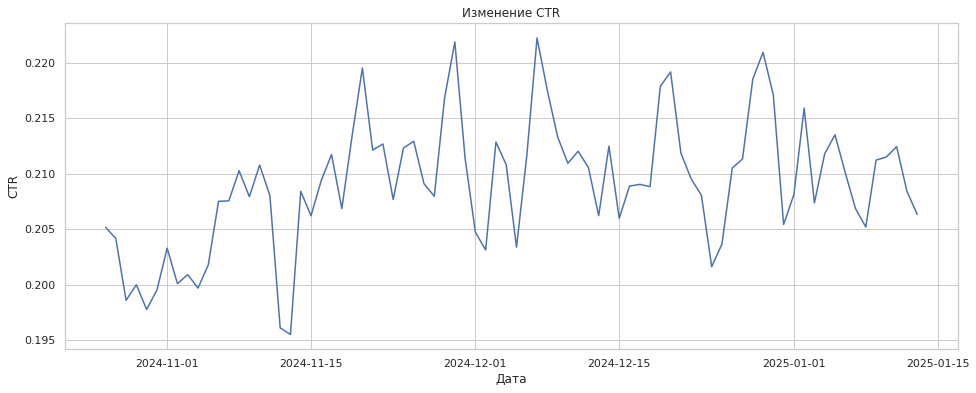

In [63]:
sns.lineplot(x='date', y='ctr', data=df_ctr)
plt.title('Изменение CTR')
plt.xlabel('Дата')
plt.ylabel('CTR');

2025-01-13 16:15:17.746647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:15:17.770187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:15:18.288801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.02)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.3% (1.12%)       3.3% (1.12%)
95% CI                    [1.1%, 5.48%]      [1.1%, 5.48%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.8%

For more details run the command: print(impact.summary('report'))


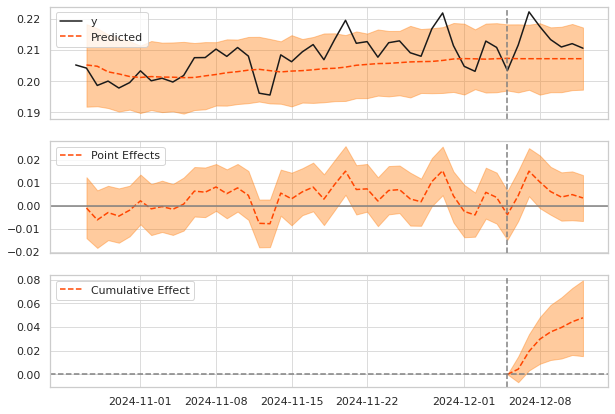

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

In [64]:
# Создание модели CausalImpact для анализа DAU
impact_dau = CausalImpact(data=df_ctr[['ctr']], pre_period=pre_period, post_period=post_period)

# Вывод результатов
print(impact_dau.summary())
impact_dau.plot()
print(impact_dau.summary('report'));

 ***Вывод: Положительный эффект CTR является статистически значимым. CTR значимо, но незначительно вырос. Средняя величина абсолютного эффекта - примерно 0.01.***

### 3. Число просмотров

Отдельный датафрейм df_views

In [68]:
 q = """
SELECT time::date as date, 
       SUM(action = 'view') as views
FROM simulator_20241220.feed_actions
GROUP BY date
"""
df_views = ph.read_clickhouse(q, connection=connection)
df_views = df_views.set_index('date')
df_views.head()

,views
date,
2024-10-26,7603
2024-10-27,62770
2024-10-28,105526
2024-10-29,118996
2024-10-30,174454


График

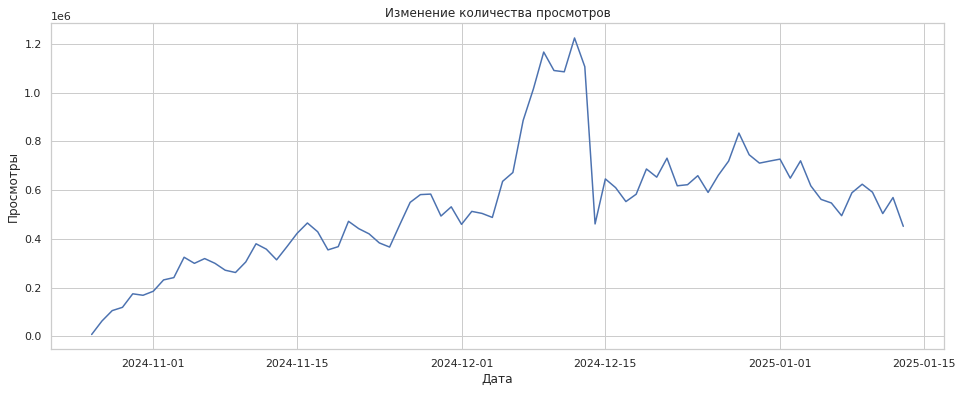

In [69]:
sns.lineplot(x='date', y='views', data=df_views)
plt.title('Изменение количества просмотров')
plt.xlabel('Дата')
plt.ylabel('Просмотры');

2025-01-13 16:22:46.900972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:22:46.923573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:22:47.417816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         363709.19 (51240.86)2545964.25 (358685.99)
95% CI                    [260275.89, 461136.41][1821931.27, 3227954.81]

Absolute effect (s.d.)    656238.12 (51240.86)4593667.0 (358685.99)
95% CI                    [558810.91, 759671.42][3911676.19, 5317699.73]

Relative effect (s.d.)    180.43% (14.09%)   180.43% (14.09%)
95% CI                    [153.64%, 208.87%] [153.64%, 208.87%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


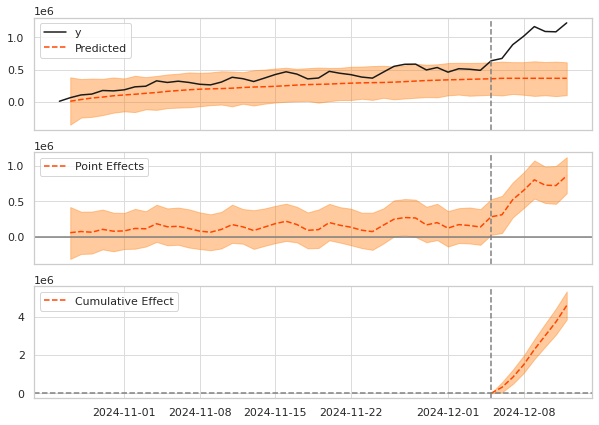

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 363709.19.
The 95% interval of this counterfactual prediction is [260275.89, 461136.41].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 656238.12 with a 95% interval of
[558810.91, 759671.42]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2545964.25. The 95% interval of this prediction is [1821931.27, 3227954.81].


The above results are given in terms of absolute num

In [70]:
impact_views = CausalImpact(data=df_views[['views']], pre_period=pre_period, post_period=post_period)
# Вывод результатов
print(impact_views.summary())
impact_views.plot()
print(impact_views.summary('report'));

****Вывод: Положительные эффект количества просмотров является статистически значимым. Число просмотров значимо выросло. Средняя величина абсолютного эффекта - примерно 656238.****

### 4. Новые посты

Отдельный датафрейм df_new_posts

In [73]:
n = """
SELECT start_date,  
       count(DISTINCT post_id) as new_post_id
FROM
    (SELECT post_id,
            MIN(time::date) as start_date
    FROM simulator_20241220.feed_actions
    GROUP BY  post_id 
    ORDER BY start_date) t1
GROUP BY start_date
"""
df_new_posts = ph.read_clickhouse(n, connection=connection)
df_new_posts = df_new_posts.set_index('start_date')
df_new_posts.head()

,new_post_id
start_date,
2024-10-26,89
2024-10-27,97
2024-10-28,61
2024-10-29,87
2024-10-30,70


График

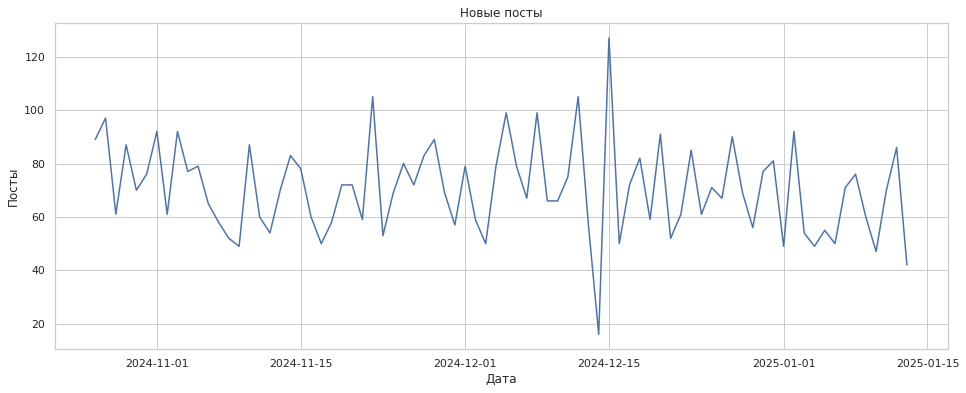

In [74]:
sns.lineplot(x='start_date', y='new_post_id', data=df_new_posts)
plt.title('Новые посты')
plt.xlabel('Дата')
plt.ylabel('Посты');

2025-01-13 16:30:42.047177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:30:42.076426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:30:42.638369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         72.03 (4.94)       504.2 (34.59)
95% CI                    [61.99, 81.36]     [433.92, 569.5]

Absolute effect (s.d.)    7.54 (4.94)        52.8 (34.59)
95% CI                    [-1.79, 17.58]     [-12.5, 123.08]

Relative effect (s.d.)    10.47% (6.86%)     10.47% (6.86%)
95% CI                    [-2.48%, 24.41%]   [-2.48%, 24.41%]

Posterior tail-area probability p: 0.07
Posterior prob. of a causal effect: 93.31%

For more details run the command: print(impact.summary('report'))


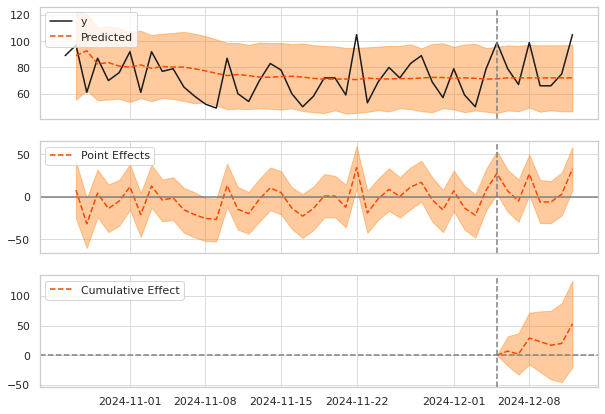

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79.57. In the absence of an
intervention, we would have expected an average response of 72.03.
The 95% interval of this counterfactual prediction is [61.99, 81.36].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 7.54 with a 95% interval of
[-1.79, 17.58]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 557.0.
Had the intervention not taken place, we would have expected
a sum of 504.2. The 95% interval of this prediction is [433.92, 569.5].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +10.4

In [75]:
impact_new_posts = CausalImpact(data=df_new_posts[['new_post_id']], pre_period=pre_period, post_period=post_period)
# Вывод результатов
print(impact_new_posts.summary())
impact_new_posts.plot()
print(impact_new_posts.summary('report'));

****Вывод: Положительный эффект новых постов не является статистически значимым. Число новых постов значимо не изменилось. Средняя величина абсолютного эффекта - примерно 8.****

### 4. Уникальные просматриваемые посты

ОТдельный датафрейм df_posts

In [79]:
p = """
SELECT time::date as date, 
       COUNT(DISTINCT post_id) as posts
FROM simulator_20241220.feed_actions
GROUP BY date
"""
df_posts = ph.read_clickhouse(p, connection=connection)
df_posts = df_posts.set_index('date')
df_posts.head()

,posts
date,
2024-10-26,89
2024-10-27,178
2024-10-28,191
2024-10-29,211
2024-10-30,214


График

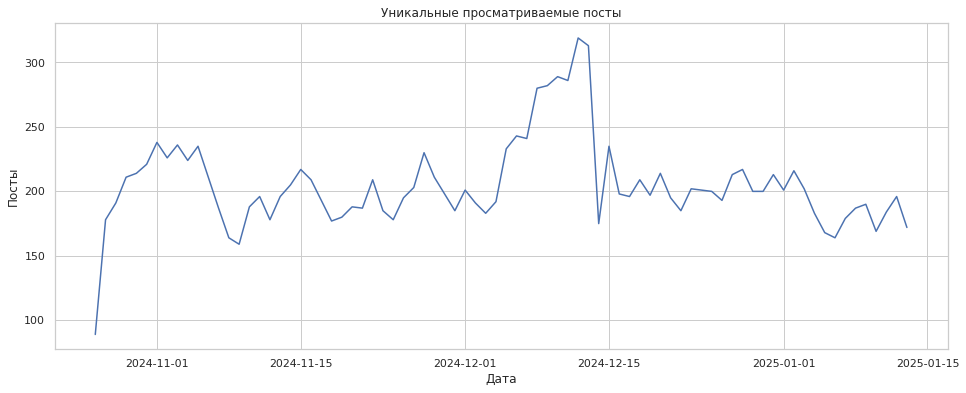

In [80]:
sns.lineplot(x='date', y='posts', data=df_posts)
plt.title('Уникальные просматриваемые посты')
plt.xlabel('Дата')
plt.ylabel('Посты');

2025-01-13 16:35:54.979364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:35:54.999793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:35:55.499021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2025-01-13 16:

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.14             1940.0
Prediction (s.d.)         197.32 (9.22)      1381.27 (64.57)
95% CI                    [178.81, 214.97]   [1251.7, 1504.81]

Absolute effect (s.d.)    79.82 (9.22)       558.73 (64.57)
95% CI                    [62.17, 98.33]     [435.19, 688.3]

Relative effect (s.d.)    40.45% (4.67%)     40.45% (4.67%)
95% CI                    [31.51%, 49.83%]   [31.51%, 49.83%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


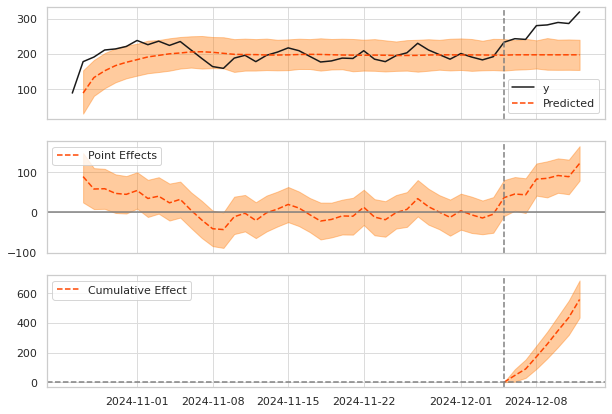

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 277.14. By contrast, in the absence of an
intervention, we would have expected an average response of 197.32.
The 95% interval of this counterfactual prediction is [178.81, 214.97].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 79.82 with a 95% interval of
[62.17, 98.33]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1940.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 1381.27. The 95% interval of this prediction is [1251.7, 1504.81].


The above results are given in terms of absolute numbers. In relative
terms, the response 

In [82]:
impact_posts = CausalImpact(data=df_posts[['posts']], pre_period=pre_period, post_period=post_period)
# Вывод результатов
print(impact_posts.summary())
impact_posts.plot()
print(impact_posts.summary('report'));

****Вывод: Положительныq эффект уникальных просматриваемых постов является статистически значимым. Число уникальных просматриваемых постов значимо выросло. Средняя величина абсолютного эффекта - примерно 79.****

***Общий вывод: эффект от флешмоба был временный***

**Чем активнее наши пользователи – тем выше нагрузка на сервера. 
И в последнее время нам всё чаще приходят жалобы, что приложение подвисает.**

Метрики для прогнозирования - это метрики, которые будут влиять на загрузку сервера.
Это должны быть количественные метрики, например, DAU, количество действий пользователей (лайки, просмотры), кол-во сообщений.

Временное рарешение изначально возтьму почасовое, далее буду смотреть. В итоге взял по дневное.

Отличаться от общего временного ряда будет время проведения флешмоба, поэтом в качестве реграссора необходима будет вспомогательная метрика на время проведения флешмоба. Можно будет это сделать ввиде отдельной колонки в датафрейме. 

Изначально возьмем даипазон прогнозирования 30 дней, по результатам будет видно  хватает ли данных

In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import numpy as np

import orbit #общий пакет
from orbit.models import DLT, KTR #варианты модели
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.metrics import rmsse, mae # метрика 
import arviz as az

Датафрейм действий пользователей, DAU

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

q = """
SELECT toStartOfDay(time) time,
       COUNT(action) AS actions,
       COUNT(DISTINCT user_id) AS dau
FROM   simulator_20241220.feed_actions
WHERE  time != toDate(now())                  --исключить последний день, о все портит
GROUP BY time  
ORDER BY time  
"""
df = ph.read_clickhouse(q, connection=connection)
df.tail()

,time,actions,dau
81,2025-01-15,955103,18673
82,2025-01-16,878711,18594
83,2025-01-17,856806,18300
84,2025-01-18,909454,18729
85,2025-01-19,765162,19017


Датафрейм сообщений

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

query = '''
SELECT    toStartOfDay(time) time, 
          COUNT(receiver_id) mes
FROM      simulator_20241220.message_actions
WHERE  time != toDate(now())                  --исключить последний день, о все портит
GROUP BY  time
ORDER BY  time
'''

mes = ph.read_clickhouse(query, connection=connection)
mes.head()

,time,mes
0,2024-10-26,3226
1,2024-10-27,12895
2,2024-10-28,12897
3,2024-10-29,12897
4,2024-10-30,12898


Соединим датафреймы в один

In [4]:
all_df = df.merge(mes)
all_df.head()

,time,actions,dau,mes
0,2024-10-26,9163,878,3226
1,2024-10-27,75586,2238,12895
2,2024-10-28,126484,3105,12897
3,2024-10-29,142796,3721,12897
4,2024-10-30,208958,4617,12898


In [5]:
all_df.tail()

,time,actions,dau,mes
81,2025-01-15,955103,18673,12900
82,2025-01-16,878711,18594,12900
83,2025-01-17,856806,18300,12896
84,2025-01-18,909454,18729,12899
85,2025-01-19,765162,19017,12901


In [6]:
all_df.shape

(86, 4)

Сообщения это тоже активность, влияющая на сервер, можно ее прибавить и добавить еще один столбец

In [7]:
all_df["all_active"] = all_df["actions"] + all_df["mes"]
all_df.head()

,time,actions,dau,mes,all_active
0,2024-10-26,9163,878,3226,12389
1,2024-10-27,75586,2238,12895,88481
2,2024-10-28,126484,3105,12897,139381
3,2024-10-29,142796,3721,12897,155693
4,2024-10-30,208958,4617,12898,221856


In [8]:
#шаблон для графика
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

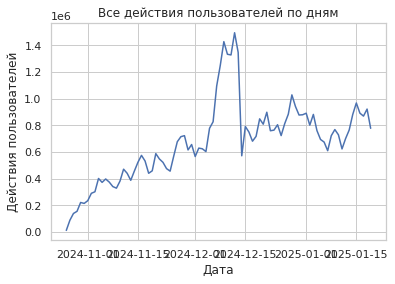

In [9]:
sns.lineplot(data=all_df, x='time', y='all_active')
plt.title('Все действия пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Действия пользователей'); 

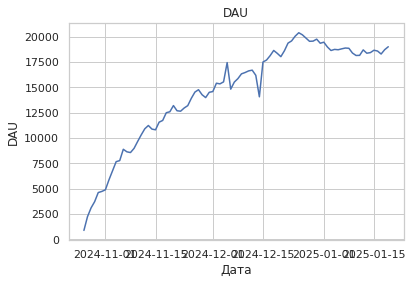

In [10]:
sns.lineplot(data=all_df, x='time', y='dau')
plt.title('DAU')
plt.xlabel('Дата')
plt.ylabel('DAU'); 

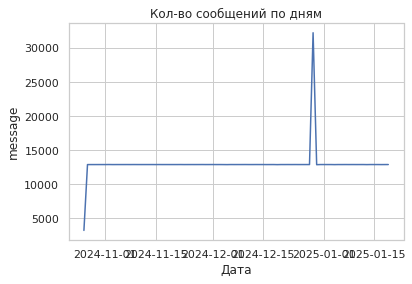

In [11]:
sns.lineplot(data=all_df, x='time', y='mes')
plt.title('Кол-во сообщений по дням')
plt.xlabel('Дата')
plt.ylabel('message'); 

***Попробую спрогнозировать рост DAU и дальнейшую нагрузку на сервера (all_active)***:
видно только резкий скачок кол-ва действий пользователей во время флешмоба, но роста кол-ва сообщений не наблюдается. Видимого роста DAU также не наблюдается.

In [12]:
#попытка убрать логи и предупреждения
import logging
import warnings

logging.getLogger("orbit").setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

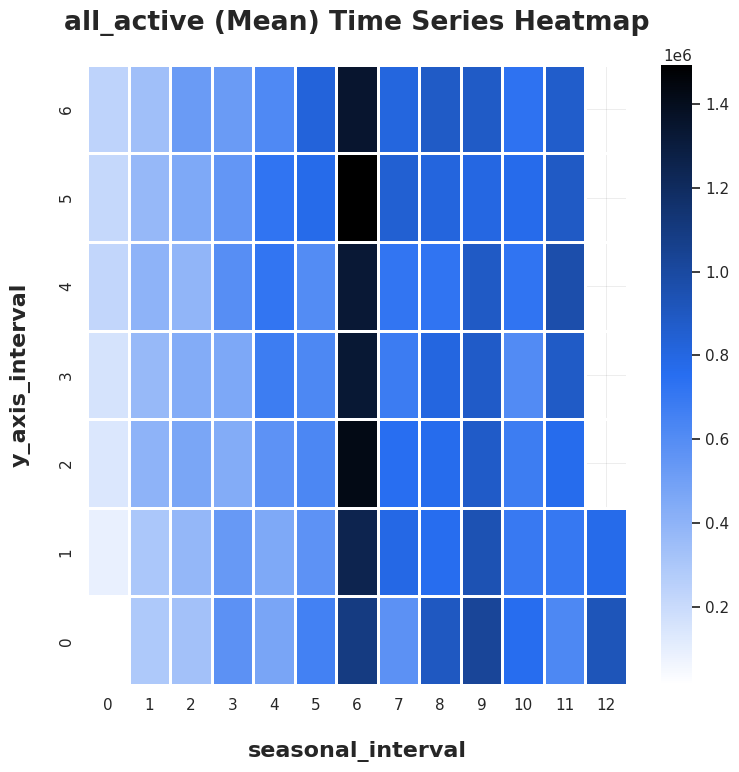

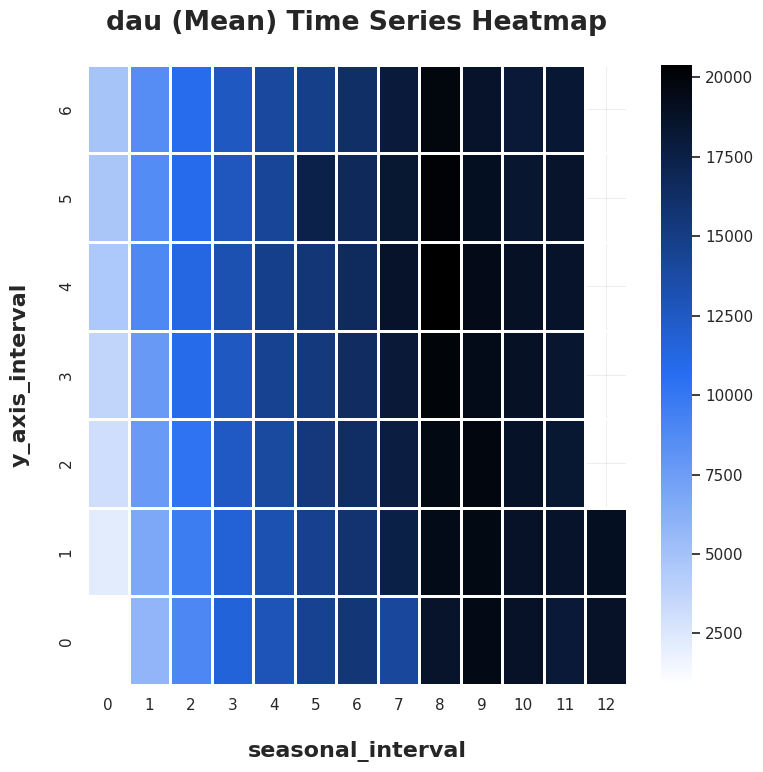

In [13]:
from orbit.eda import eda_plot

#тепловая карта c периодом в 7 дней
_ = eda_plot.ts_heatmap(df=all_df, date_col="time", value_col="all_active", seasonal_interval=7, normalization=False)
_ = eda_plot.ts_heatmap(df=all_df, date_col="time", value_col="dau", seasonal_interval=7, normalization=False)

Можно отметить бинарной переменной период флешмоба. В эти даты будет 1. И включу в этот датафрейм дату 2024-12-05 - выброс DAU и дату 2024-12-14 - провал DAU из-за технических проблем.

In [14]:
#2024-12-06 по 2024-12-12
all_df["flashmob"] = np.where((all_df.time >= "2024-12-05") & (all_df.time <= "2024-12-14") , 1, 0)
all_df.tail()

,time,actions,dau,mes,all_active,flashmob
81,2025-01-15,955103,18673,12900,968003,0
82,2025-01-16,878711,18594,12900,891611,0
83,2025-01-17,856806,18300,12896,869702,0
84,2025-01-18,909454,18729,12899,922353,0
85,2025-01-19,765162,19017,12901,778063,0


Для единообразия данных их необходимо стандиртизировать, разделив на sd
Метод описан здесь: https/www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/

In [15]:
#среднее всех действий
aa_mean = all_df.all_active.mean()
#стандартное отлклонение всех действий
aa_sd = all_df.all_active.std()
aa_mean, aa_sd

(673143.4418604651, 296402.7510512802)

In [16]:
#среднее dau
dau_mean = all_df.dau.mean()
#стандартное отклонение dau
dau_sd = all_df.dau.std()
dau_mean, dau_sd

(14544.313953488372, 4961.849672336097)

In [17]:
#теперь усредним данные по всему датафрему
all_df["dau_standart"] = (all_df.dau - dau_mean) / dau_sd
all_df["aa_standart"] = (all_df.all_active - aa_mean) / aa_sd
all_df

,time,actions,dau,mes,all_active,flashmob,dau_standart,aa_standart
0,2024-10-26,9163,878,3226,12389,0,-2.754278,-2.229245
1,2024-10-27,75586,2238,12895,88481,0,-2.480187,-1.972527
2,2024-10-28,126484,3105,12897,139381,0,-2.305454,-1.800801
3,2024-10-29,142796,3721,12897,155693,0,-2.181306,-1.745768
4,2024-10-30,208958,4617,12898,221856,0,-2.000728,-1.522548
...,...,...,...,...,...,...,...,...
81,2025-01-15,955103,18673,12900,968003,0,0.832086,0.994794
82,2025-01-16,878711,18594,12900,891611,0,0.816165,0.737063
83,2025-01-17,856806,18300,12896,869702,0,0.756913,0.663147
84,2025-01-18,909454,18729,12899,922353,0,0.843372,0.840780


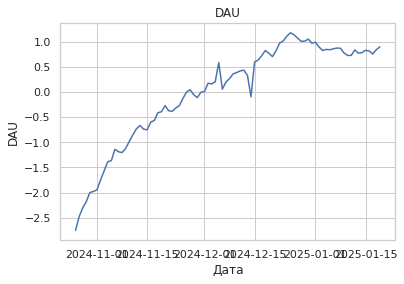

In [18]:
sns.lineplot(data=all_df, x='time', y='dau_standart')
plt.title('DAU')
plt.xlabel('Дата')
plt.ylabel('DAU'); 

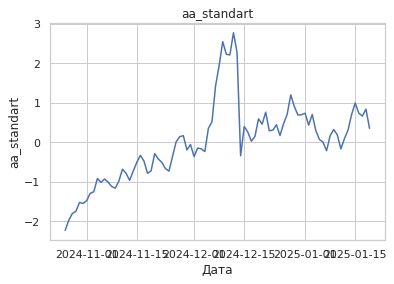

In [19]:
sns.lineplot(data=all_df, x='time', y='aa_standart')
plt.title('aa_standart')
plt.xlabel('Дата')
plt.ylabel('aa_standart'); 

Можно будет использовать DAU в стандартизированном виде - как регрессор

# Построение моделей

Из представленных на https://orbit-ml.readthedocs.io/en/stable/tutorials/dlt.html моделей можно выбрать разные виды Global Trend Configurations:\
    1.linear \
    2.loglinear \
    3.flat\
    4.logistic

Cогласно https://orbit-ml.readthedocs.io/en/stable/tutorials/model_estimations_predictions.html можно выбрать разные виды Methods of Estimations and Predictions:\
    1.estimator='stan-map'    
    2.estimator='stan-mcmc'

Исходя из представленных примеров на сайте Орбита, я выбираю следующие модели, которые мне кажутся наиболее точными:\
    1.stan-mcmc + linear\
    2.stan-mcmc + logistic\
    3.stan-mcmc + linear + регрессор DAU стандартизированный\
    4.stan-mcmc + logistic + регрессор DAU стандартизированный\
    5.stan-mcmc + linear + регрессор DAU стандартизированный + влияние Флешмоба\
    6.stan-mcmc + logistic + регрессор DAU стандартизированный + влияние Флешмоба

In [20]:
DLT_lin = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="linear",
               num_warmup=10000,
               num_sample=10000)
DLT_log = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="logistic",
               num_warmup=10000,
               num_sample=10000)
dau_lin = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="linear",
               regressor_col=["dau_standart"], regressor_sign=["+"],
               num_warmup=10000,
               num_sample=10000)
dau_log = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="logistic",
               regressor_col=["dau_standart"], regressor_sign=["+"],
               num_warmup=10000,
               num_sample=10000)
flashmob_lin = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="linear",
               regressor_col=["dau_standart", "flashmob"], regressor_sign=["+", "+"],
               num_warmup=10000,
               num_sample=10000)
flashmob_log = DLT (response_col="aa_standart",
               date_col="time", 
               estimator="stan-mcmc", 
               global_trend_option="logistic",
               regressor_col=["dau_standart", "flashmob"], regressor_sign=["+", "+"],
               num_warmup=10000,
               num_sample=10000)

In [21]:
#обучение моделей
DLT_lin.fit(all_df)
DLT_log.fit(all_df)
dau_lin.fit(all_df)
dau_log.fit(all_df)
flashmob_lin.fit(all_df)
flashmob_log.fit(all_df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

***Датафрейм с горизонтом прогнозирования - то есть теми датами, которые мы хотим предсказать на которые будет распространяться предстказание.\
Для этого есть метод .make_future_df().\
Возьму горизонт 40 дней***

In [22]:
#сформирую списком все модели, чтобы каждый раз не копировать
models = [DLT_lin, DLT_log, dau_lin, dau_log, flashmob_lin, flashmob_log]

In [23]:
future_df = models[0].make_future_df(periods=40) 
future_df.head()

,time
0,2025-01-20
1,2025-01-21
2,2025-01-22
3,2025-01-23
4,2025-01-24


In [24]:
#для начала мне необходимо создать прогноз для моделей без регрессора
predict_dlt_lin = models[0].predict(df=future_df)
predict_dlt_lin.head()

,time,prediction_5,prediction,prediction_95
0,2025-01-20,-0.064292,0.477648,1.004549
1,2025-01-21,-0.224199,0.510515,1.213470
2,2025-01-22,-0.349982,0.545062,1.424552
3,2025-01-23,-0.468302,0.581223,1.620422
4,2025-01-24,-0.558349,0.625582,1.824051


In [25]:
predict_dlt_log = models[1].predict(df=future_df)
predict_dlt_log.head()

,time,prediction_5,prediction,prediction_95
0,2025-01-20,-0.137842,0.413937,0.970444
1,2025-01-21,-0.366732,0.413852,1.161600
2,2025-01-22,-0.544910,0.400785,1.295972
3,2025-01-23,-0.696558,0.402589,1.429935
4,2025-01-24,-0.848054,0.401456,1.558995


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

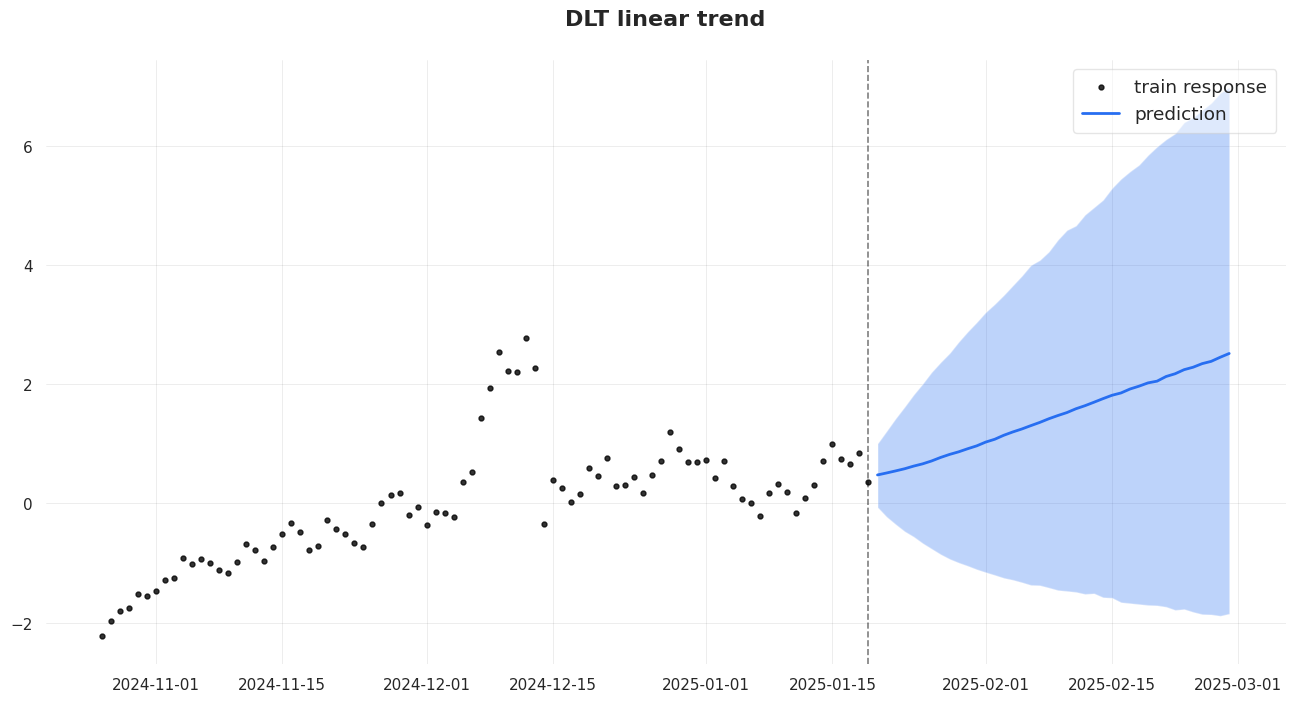

In [26]:
_ = plot_predicted_data(all_df, predict_dlt_lin, "time", 'aa_standart', title='DLT linear trend')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

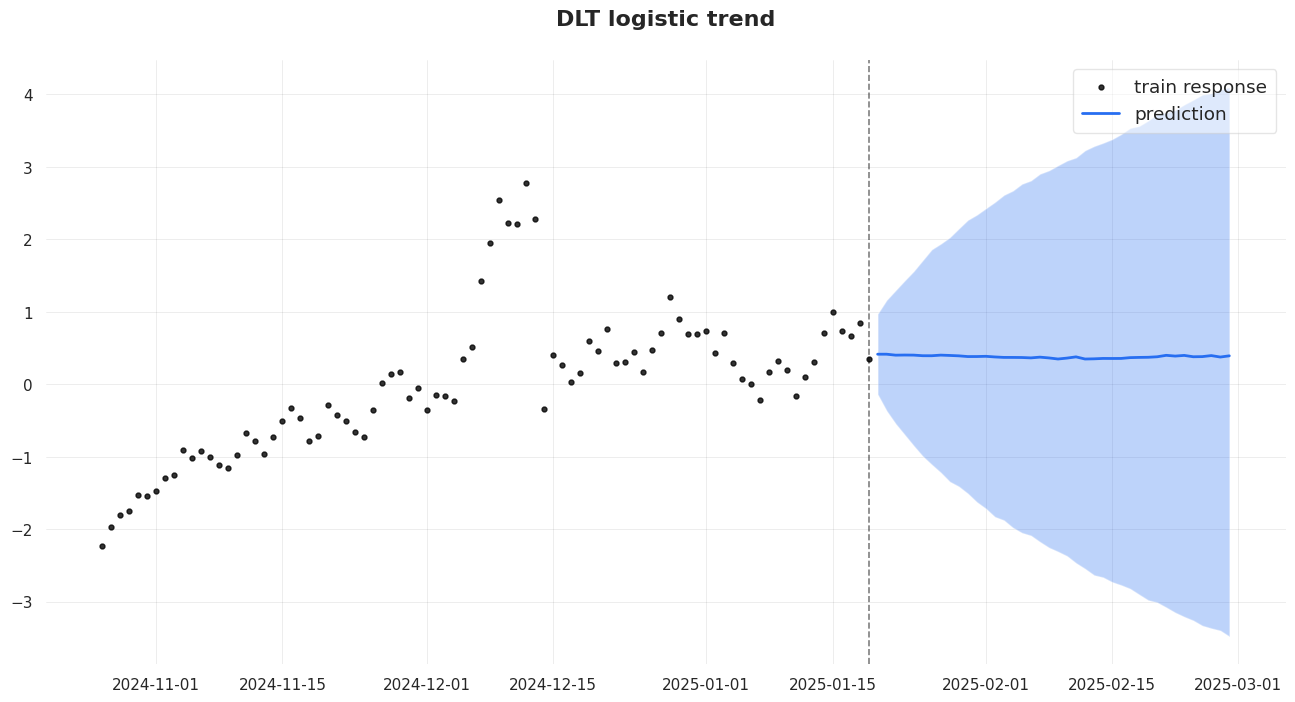

In [27]:
_ = plot_predicted_data(all_df, predict_dlt_log, "time", 'aa_standart', title='DLT logistic trend')

In [28]:
#чтобы работать с моделями с регрессором, необходимо добавить будущие значения этого самого регрессора, а для этого надо их вычислить в новой модели
dau_future = DLT(response_col="dau_standart", 
                 date_col="time", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)
dau_future.fit(all_df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [29]:
dau_predict_lin = dau_future.predict(future_df)
dau_predict_lin.head()

,time,prediction_5,prediction,prediction_95
0,2025-01-20,0.753396,0.939490,1.124845
1,2025-01-21,0.706118,0.982423,1.254689
2,2025-01-22,0.667757,1.023667,1.384534
3,2025-01-23,0.636454,1.067010,1.510945
4,2025-01-24,0.602365,1.112702,1.629689


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

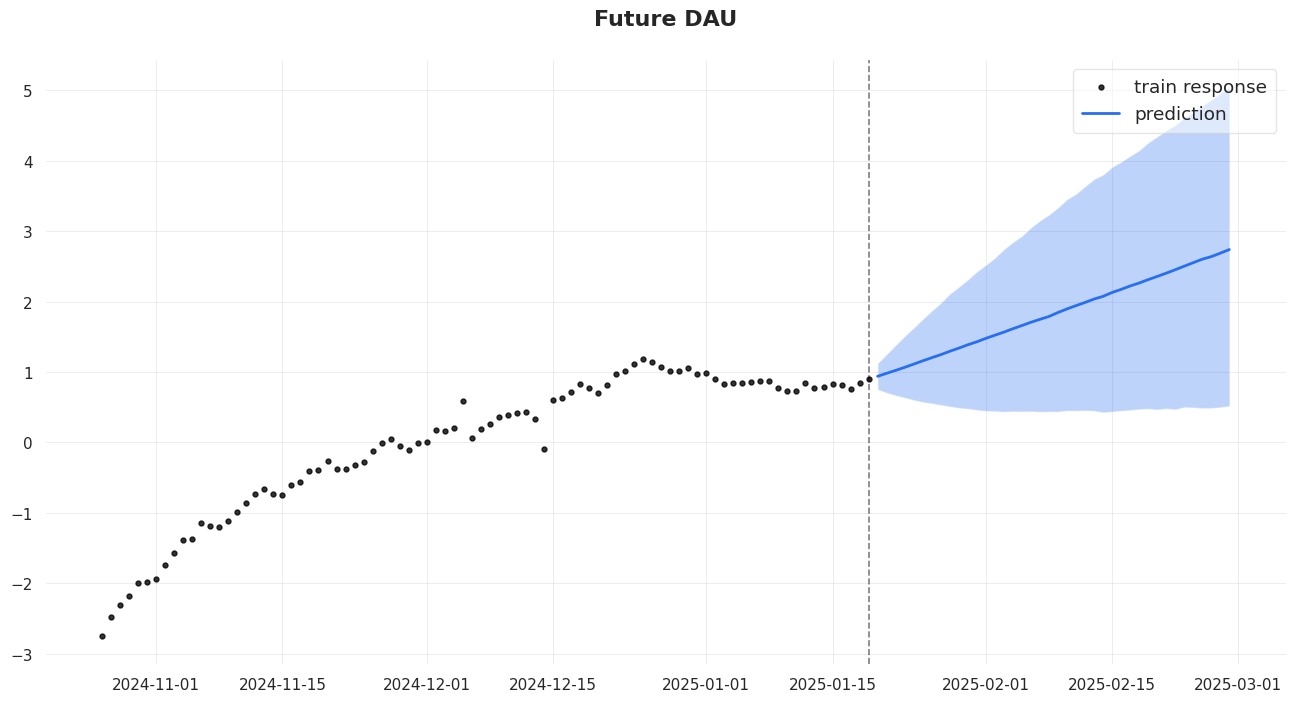

In [30]:
_ = plot_predicted_data(all_df, dau_predict_lin, "time", 'dau_standart', title='Future DAU')

In [31]:
#теперь эту прогнозные значения dau можно доавбить в датафрейм с прогнозными ДАТАМИ
future_df["dau_standart"] = dau_predict_lin.prediction
future_df.head()

,time,dau_standart
0,2025-01-20,0.939490
1,2025-01-21,0.982423
2,2025-01-22,1.023667
3,2025-01-23,1.067010
4,2025-01-24,1.112702


In [32]:
#использую dlt_lin с регрессором, где автоматически выберется будущие значения dau для расчета коэффициентов регрессии
models[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,dau_standart,Positive,0.793693,0.306979,1.263036,1.0,0.0


In [33]:
#прогноз следующих моделей
predict_dau_lin = models[2].predict(future_df)
predict_dau_log = models[3].predict(future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

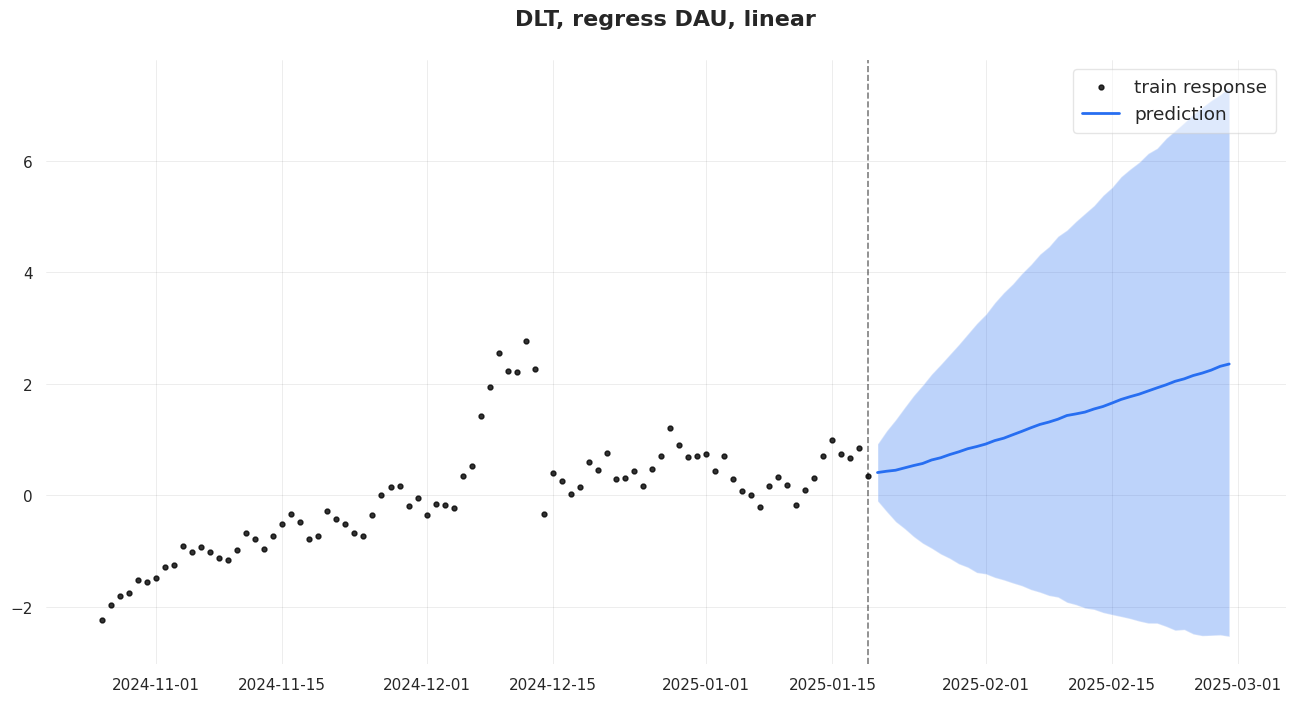

In [34]:
_ = plot_predicted_data(all_df, predict_dau_lin, "time", 'aa_standart', title='DLT, regress DAU, linear')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

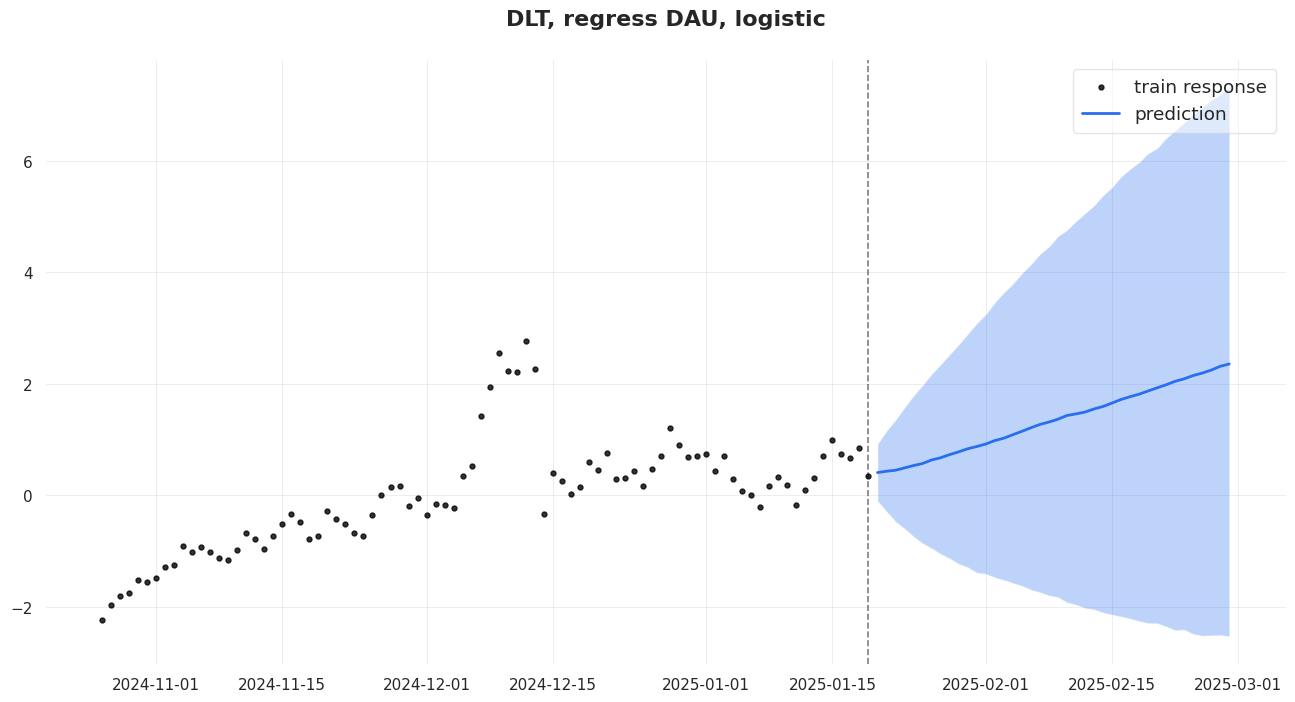

In [35]:
_ = plot_predicted_data(all_df, predict_dau_lin, "time", 'aa_standart', title='DLT, regress DAU, logistic')

In [36]:
#добавлю в будущий датафрейм бинарные значения в даты флешмоба и в даты провалов и взлетов
future_df["flashmob"] = 0
future_df.head()

,time,dau_standart,flashmob
0,2025-01-20,0.939490,0
1,2025-01-21,0.982423,0
2,2025-01-22,1.023667,0
3,2025-01-23,1.067010,0
4,2025-01-24,1.112702,0


In [37]:
predict_flashmob_lin = models[4].predict(future_df)
predict_flashmob_log = models[5].predict(future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

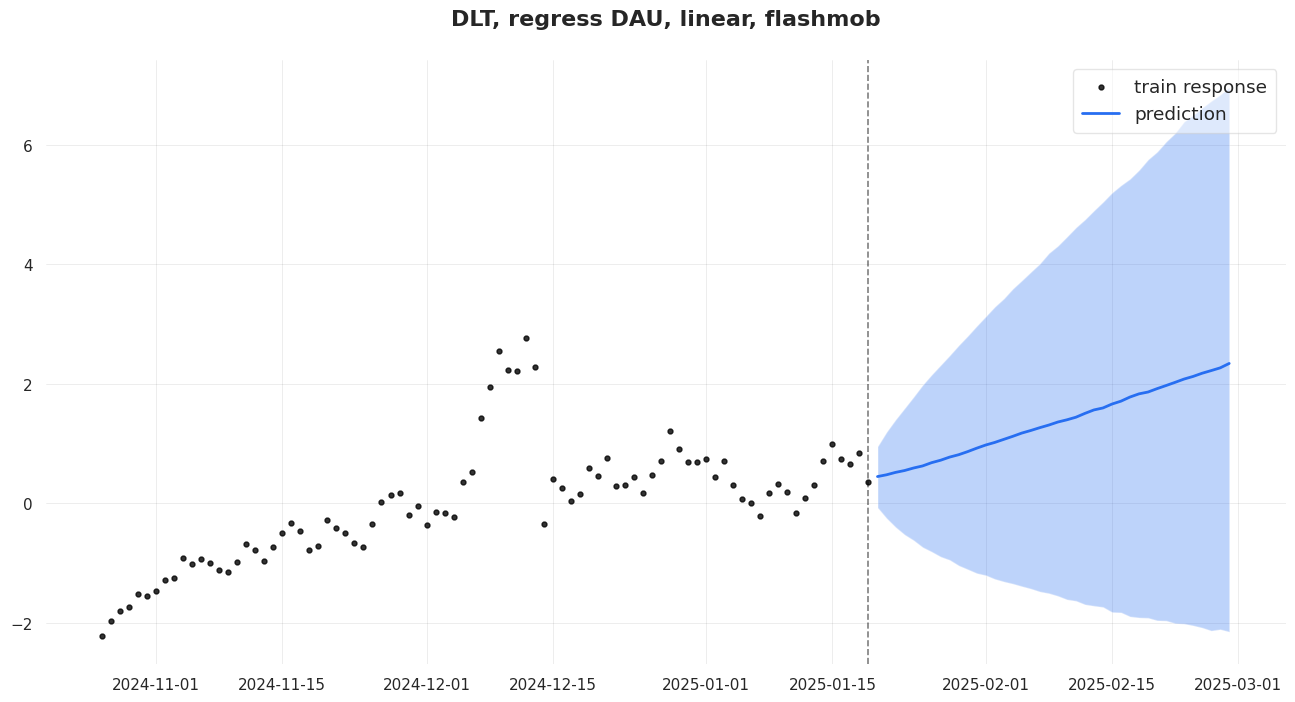

In [38]:
_ = plot_predicted_data(all_df, predict_flashmob_lin, "time", 'aa_standart', title='DLT, regress DAU, linear, flashmob')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

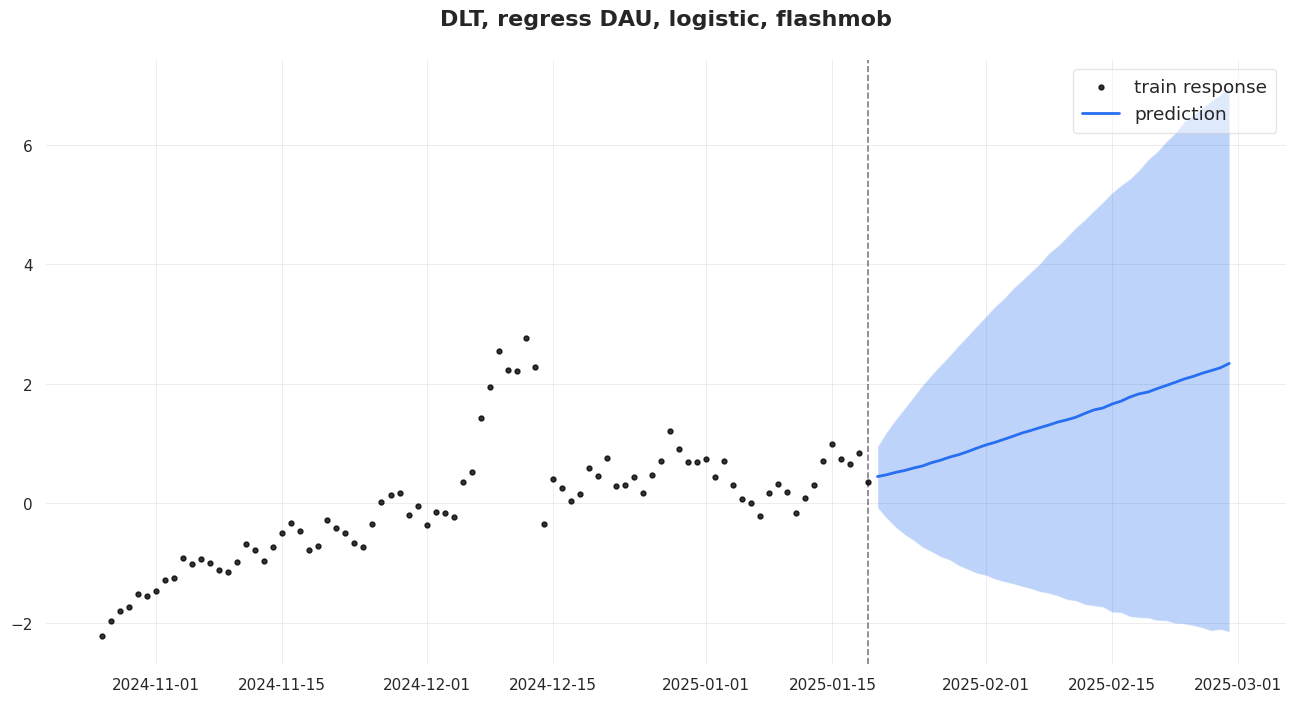

In [39]:
_ = plot_predicted_data(all_df, predict_flashmob_lin, "time", 'aa_standart', title='DLT, regress DAU, logistic, flashmob')

# Проверка качества моделей

Использую концепцию бэктестинга для моеделй без реграссора и для модели с регрессором и флешмобом

Принцип плавающего окна

In [46]:
#DLT_lin_roll
bt_dlt_lin_roll = BackTester(
    model=DLT_lin, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="rolling") #тип окна
bt_dlt_lin_roll.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [47]:
bt_dlt_lin_roll.score() #метрики

,metric_name,metric_values,is_training_metric
0,smape,1.005486,False
1,wmape,1.037849,False
2,mape,4.575605,False
3,mse,1.118282,False
4,mae,0.701542,False
5,rmsse,2.491563,False


In [53]:
#DLT_lin_exp
bt_dlt_lin_exp = BackTester(
    model=DLT_lin, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding") #тип окна
bt_dlt_lin_exp.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [54]:
bt_dlt_lin_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.895402,False
1,wmape,0.891666,False
2,mape,4.739650,False
3,mse,0.811375,False
4,mae,0.602729,False
5,rmsse,2.122300,False


In [55]:
#DLT_log_roll
bt_dlt_log_roll = BackTester(
    model=DLT_log, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="rolling") #тип окна
bt_dlt_log_roll.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [56]:
bt_dlt_log_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,0.820946,False
1,wmape,0.916971,False
2,mape,4.380165,False
3,mse,0.837752,False
4,mae,0.619834,False
5,rmsse,2.156522,False


In [57]:
#dlt_log_exp
bt_dlt_log_exp = BackTester(
    model=DLT_log, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding") #тип окна
bt_dlt_log_exp.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [58]:
bt_dlt_log_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.795645,False
1,wmape,0.868223,False
2,mape,4.326527,False
3,mse,0.789027,False
4,mae,0.586882,False
5,rmsse,2.092869,False


In [59]:
#flashmob_lin
bt_flashmob_lin_roll = BackTester(
    model=flashmob_lin, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="rolling") #тип окна
bt_flashmob_lin_roll.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [60]:
bt_flashmob_lin_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,1.050655,False
1,wmape,1.055953,False
2,mape,4.342694,False
3,mse,1.075389,False
4,mae,0.713780,False
5,rmsse,2.443312,False


In [61]:
#flashmob_lin
bt_flashmob_lin_exp = BackTester(
    model=flashmob_lin, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding") #тип окна
bt_flashmob_lin_exp.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [62]:
bt_flashmob_lin_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.835580,False
1,wmape,0.845701,False
2,mape,4.392982,False
3,mse,0.729746,False
4,mae,0.571658,False
5,rmsse,2.012713,False


In [63]:
#flashmob_log
bt_flashmob_log_roll = BackTester(
    model=flashmob_log, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="rolling") #тип окна
bt_flashmob_log_roll.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [64]:
bt_flashmob_log_roll.score()

,metric_name,metric_values,is_training_metric
0,smape,0.936820,False
1,wmape,0.860167,False
2,mape,3.649603,False
3,mse,0.681474,False
4,mae,0.581437,False
5,rmsse,1.945005,False


In [65]:
#flashmob_log
bt_flashmob_log_exp = BackTester(
    model=flashmob_log, #модели
    df=all_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение, НЕДЕЛЯ
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding") #тип окна
bt_flashmob_log_exp.fit_predict() #обучение

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [66]:
bt_flashmob_log_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,0.841749,False
1,wmape,0.844374,False
2,mape,4.240305,False
3,mse,0.753206,False
4,mae,0.570761,False
5,rmsse,2.044809,False


***После проверки скользующим окном:\
Самая лучшая модель по метрике smape - DLT_log\
Самая лучшая модель по метрике wmape - flashmob_log\
Самая лучшая модель по метрике mape - flashmob_log\
Самая лучшая модель по метрике mse - flashmob_log\
Самая лучшая модель по метрике mae - flashmob_log\
Самая лучшая модель по метрике rmsse - flashmob_log***

***После проверки расширяющимся окном:\
Самая лучшая модель по метрике smape - DLT_log\
Самая лучшая модель по метрике wmape - flashmob_log\
Самая лучшая модель по метрике mape - flashmob_log\
Самая лучшая модель по метрике mse - flashmob_log\
Самая лучшая модель по метрике mae - flashmob_log\
Самая лучшая модель по метрике rmsse - flashmob_log***

In [71]:
#проверю весь список моделей на качество другим методом
for model in models:
    
    model.fit_wbic(all_df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [72]:
#результаты
for number, model in enumerate(models):
    
    print(f"Модель {number+1}, WBIC = {model.get_wbic()}")

Модель 1, WBIC = 77.91322070450028
Модель 2, WBIC = 92.49622669244957
Модель 3, WBIC = 72.2612581234146
Модель 4, WBIC = 70.02586200915209
Модель 5, WBIC = 75.15296294155719
Модель 6, WBIC = 73.15946691502732


Данный метод почему-то показывает, что лучшая модель dau_log...

## Вывод: Выберу все-таки модель flashmob_log и допольнительно ее проверю.

In [74]:
predicted_df = models[5].predict(future_df, decompose=True)
predicted_df.head()

,time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-01-20,-0.145625,0.444109,1.053159,-1.138321,-0.369463,0.414595,0.0,0.0,0.0,0.315337,0.803858,1.305346
1,2025-01-21,-0.427569,0.435536,1.206684,-1.435722,-0.413958,0.519443,0.0,0.0,0.0,0.329747,0.840593,1.364999
2,2025-01-22,-0.690172,0.440768,1.381038,-1.717773,-0.449572,0.637246,0.0,0.0,0.0,0.343590,0.875883,1.422304
3,2025-01-23,-0.949875,0.452032,1.591439,-1.998336,-0.470872,0.785950,0.0,0.0,0.0,0.358138,0.912968,1.482524
4,2025-01-24,-1.157442,0.472435,1.776147,-2.235988,-0.491008,0.927825,0.0,0.0,0.0,0.373475,0.952064,1.546011


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

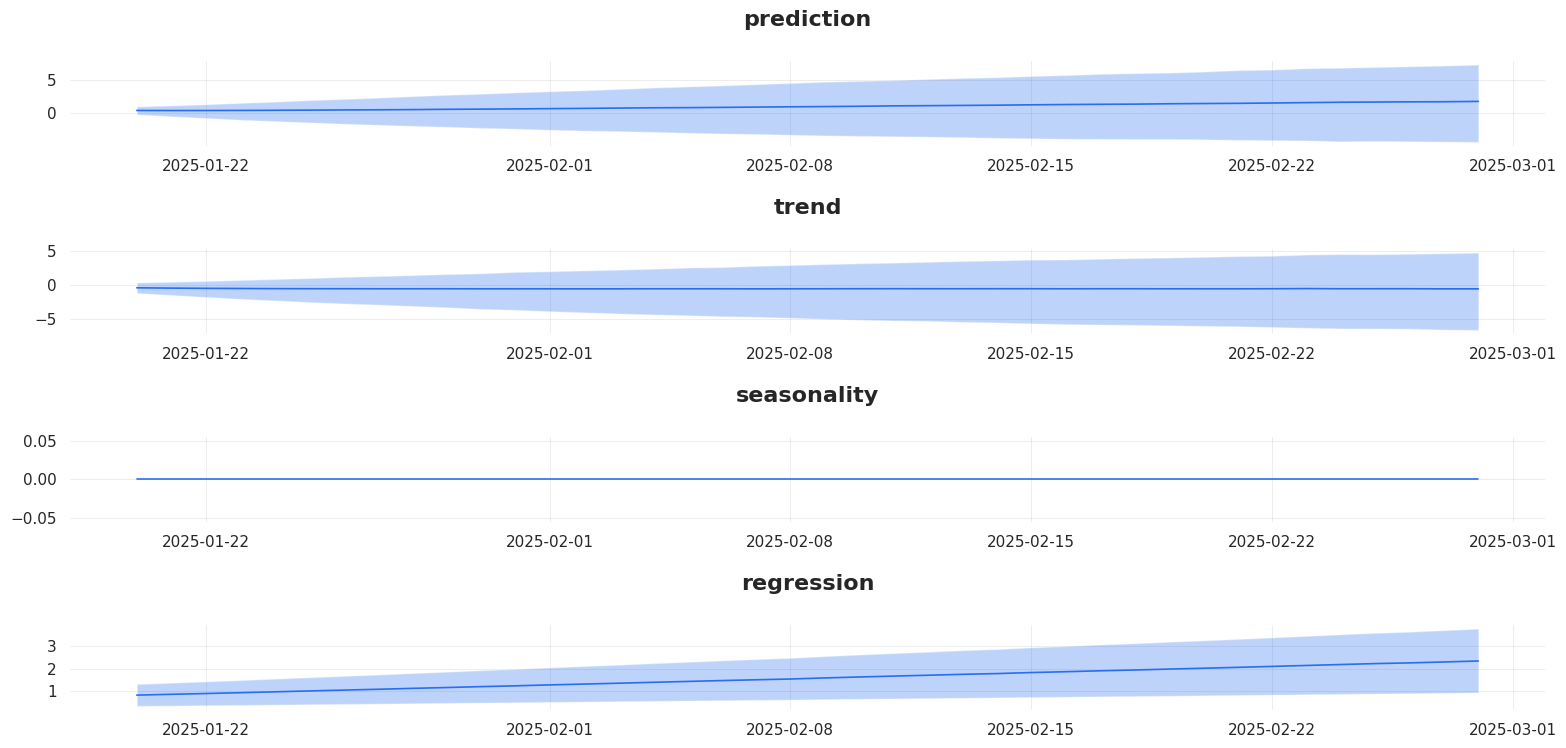

In [75]:
_ = plot_predicted_components(predicted_df, "time", plot_components=['prediction', 'trend', 'seasonality', 'regression'])

In [76]:
 # коэффициент регрессии:
    models[5].get_regression_coefs()

IndentationError: unexpected indent (1982948376.py, line 2)

In [77]:
ps = models[5].get_posterior_samples(relabel=True, permute=False)
ps.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk', 'dau_standart', 'flashmob'])

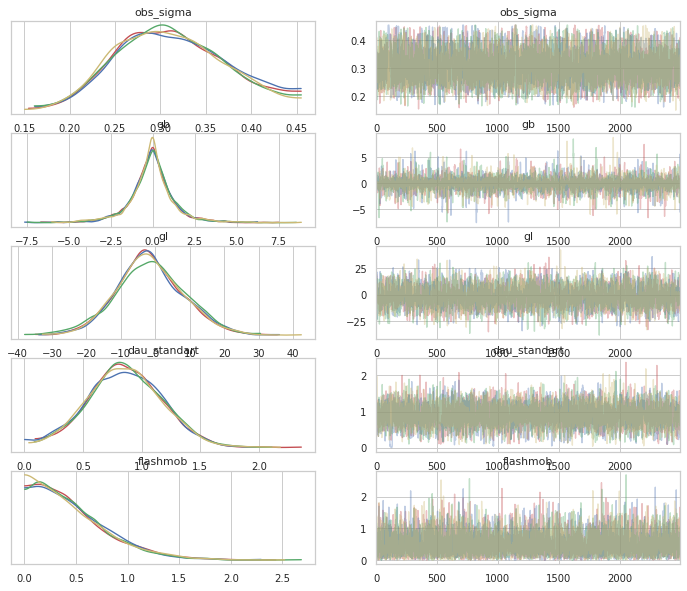

In [80]:
az.plot_trace(
    ps,
    var_names=['obs_sigma', 'gb', 'gl', 'dau_standart', 'flashmob'],
    chain_prop={"color": ['r', 'b', 'g', 'y']},
);

In [84]:
#перевод из стандартизированных единиц
predict_flashmob_log[["prediction_5", "prediction", "prediction_95"]] = predict_flashmob_log[["prediction_5", "prediction", "prediction_95"]] \
                         .apply(lambda x: (x * aa_sd) + aa_mean)

In [85]:
predict_flashmob_log.head()

,time,prediction_5,prediction,prediction_95
0,2025-01-20,648335.958144,799663.890342,9.487110e+05
1,2025-01-21,596922.582922,808798.833651,1.009554e+06
2,2025-01-22,556175.190616,816641.110522,1.071786e+06
3,2025-01-23,518271.045257,823544.515789,1.121978e+06
4,2025-01-24,483347.913352,835455.209289,1.172129e+06


In [86]:
predict_flashmob_log.tail()

,time,prediction_5,prediction,prediction_95
35,2025-02-24,140887.732354,1.226505e+06,2.272254e+06
36,2025-02-25,116012.958101,1.237434e+06,2.303587e+06
37,2025-02-26,121470.669940,1.243868e+06,2.334047e+06
38,2025-02-27,107586.812397,1.261096e+06,2.360200e+06
39,2025-02-28,123703.645806,1.272870e+06,2.382488e+06


In [87]:
1.272870e+06

1272870.0

## Выводы

 Выбрал основная метрика - действия пользователей, так как чем больше пользователь совершает действий, тем выше нагрузка на сервер.\
 Данные брал за весь период, так как их у нас не много. В качестве регрессора использовал проведение DAU и даты проведения флешмоба.\
 Так как время проведения флэшмоба было непродолжительным, а его эффект почти сразу перестал влиять, то количество действий пользователей сильно не изменилось.\
 Построил модели с регрессорами и без.\
 Самый худший результат показала модель без регрессора. Наиболее удачной оказалась модель с MCMC и DAU-регрессором и Flashmob-регрессором.\
 Данных для бэктестинга с текущей задачей не хватает на горизонт планирования 40 дней, поэтому брал неделю.\